# Preliminary direct numerical simulation of 2D Rayleigh-Bénard convection

## Theoretical formulation
We consider the nondimensionalised equations in the Boussinesq approximation given by [Busse (1978)](https://doi.org/10.1088/0034-4885/41/12/003):
$$
\begin{align*}
    \mathrm{Pr}^{-1} \left[\partial_t \vec{u} + (\vec{u} \cdot \nabla) \vec{u}\right] &= - \nabla \pi + \nabla^2 \vec{u} + \theta \hat{z}, \\
    \partial_t \theta + (\vec{u} \cdot \nabla) \theta &= \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \nabla^2 \theta, \\
    \nabla \cdot \vec{u} &= 0
\end{align*}
$$
where:
- $\vec{u} = (u,0,w)$ is the dimensionless velocity,
- $\theta$ is the dimensionless temperature perturbation from the conductive (linear) base profile,
- $\pi$ is the dimensionless pressure perturbation from the hydrostatic base profile,
- $\mathrm{Pr}$ is the Prandtl number, the ratio of kinematic viscosity to thermal diffisivity,
- $\mathrm{Ra}$ is the Rayleigh number, the ratio of the thermal diffusion time scale to the convective time scale.

The equations have been nondimensionalised using:
- The layer thickness $d$ as the length scale,
- The thermal diffusion time $d^2/D$, where $D$ is the thermal diffusivity, as the time scale, and
- A temperature perturbation scale $\delta T/\mathrm{Ra}$, where $\delta T$ is the temperature difference between the top and bottom plates.

We impose no-slip, isothermal boundary conditions at the top and bottom of the domain,
$$
\begin{alignat*}{2}
    \vec{u}(z=0) &= \vec{u}(z=L_z) &&= \vec{0}, \\
    \theta(z=0) &= \theta(z=L_z) &&= 0,
\end{alignat*}
$$
and periodic lateral boundary conditions
$$
\begin{align*}
    \vec{u}(x=0) &= \vec{u}(x=L_x),\\
    \theta(x=0) &= \theta(x=L_x).
\end{align*}
$$

### Tau terms
Dedalus requires us to add *tau terms* of the form $\tau(x) P(z)$, where $\tau$ is a new degree of freedom and $P$ is a known polynomial, to the equations. This allows the non-periodic top and bottom boundary conditions to be imposed while ensuring that the system still has exact polynomial solutions (i.e., so it is solvable using spectral methods). Following [the steps in the documentation](https://dedalus-project.readthedocs.io/en/latest/pages/tau_method.html), we introduce six new degrees of freedom
$$
    \vec{\tau}_{u1}(x) = (\tau_1(x), 0, \tau_2(x)), \quad \vec{\tau}_{u2}(x) = (\tau_3(x), 0, \tau_4(x)),
    \quad \tau_{\theta 1}(x), \quad \text{and } \tau_{\theta 2}(x).
$$
Defining the auxiliary variables
$$
\begin{align*}
    G_u &= \nabla \otimes \vec{u} - \hat{z} \otimes \vec{\tau}_{u1}(x) P(z), \\
    \vec{G}_\theta &= \nabla \theta - \hat{z} \tau_{\theta 1}(x) P(z),
\end{align*}
$$
the equations become
$$
\begin{align*}
    \mathrm{Pr}^{-1} \partial_t \vec{u} - \nabla \cdot G_u + \nabla \pi - \theta \hat{z} + \vec{\tau}_{u2}(x) P(z) &= -\mathrm{Pr}^{-1} \vec{u} \cdot G_u, \\
    \partial_t \theta - \nabla \cdot \vec{G}_\theta - \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \tau_{\theta 2}(x) P(z) &= -\vec{u} \cdot \vec{G}_\theta, \\
    \operatorname{Tr}(G_u) &= 0.
\end{align*}
$$

### Pressure gauge condition
Since only the gradient of $\pi$ appears in the equations, there is a gauge freedom in the problem: the pressure is only determined up to a constant. Dedalus requires us to explicitly specify gauge conditions, so since $\pi$ is a pressure perturbation, we may as well require its mean value to be zero:
$$\int \pi ~\mathrm{d}V = 0.$$
Following [the documentation](https://dedalus-project.readthedocs.io/en/latest/pages/gauge_conditions.html), we must also introduce a seventh spatially constant tau variable $\tau_\pi$ to the divergence equation:
$$\operatorname{Tr}(G_u) + \tau_\pi = 0.$$


### Final PDE system
The final system of equations that we will enter into Dedalus is
$$
\begin{align*}
    \mathrm{Pr}^{-1} \partial_t \vec{u} - \nabla \cdot G_u + \nabla \pi - \theta \hat{z} + \vec{\tau}_{u2}(x) P(z) &= -\mathrm{Pr}^{-1} \vec{u} \cdot G_u, \\
    \partial_t \theta - \nabla \cdot \vec{G}_\theta - \mathrm{Ra}\, (\vec{u} \cdot \hat{z}) + \tau_{\theta 2}(x) P(z) &= -\vec{u} \cdot \vec{G}_\theta, \\
    \operatorname{Tr}(G_u) + \tau_\pi = 0,
\end{align*}
$$
with the substitutions
$$
\begin{align*}
    G_u &= \nabla \otimes \vec{u} - \hat{z} \otimes \vec{\tau}_{u1}(x) P(z), \\
    \vec{G}_\theta &= \nabla \theta - \hat{z} \tau_{\theta 1}(x) P(z),
\end{align*}
$$
subject to the boundary conditions
$$
\begin{alignat*}{2}
    \vec{u}(z=0) &= \vec{u}(z=L_z) &&= \vec{0}, \\
    \theta(z=0) &= \theta(z=L_z) &&= 0, \\
    \int \pi ~\mathrm{d}V &= 0. && \\
\end{alignat*}
$$
(the periodic lateral boundaries are handled automatically by using a Fourier basis in the horizontal)

## Solution
This is adapted from [this example notebook](https://dedalus-project.readthedocs.io/en/latest/pages/examples/ivp_2d_rayleigh_benard.html) for 2D RBC in the Dedalus documentation.

In [3]:
import numpy as np
import dedalus.public as d3
import matplotlib.pyplot as plt
import glob
import xarray as xr
import logging
logger = logging.getLogger(__name__)

The choice of parameters is informed by the scales used to nondimensionalise the equations:
- The dimensionless length unit is the layer thickness $d$, so the dimensions of the domain should be on the order of unity,
- The time unit is the thermal diffusion time, which is $\mathrm{Ra}$ times larger than the convective time scale, so in order to resolve convective motions the time step should be on the order of $1/\mathrm{Ra}$,
- Convective instability only occurs for sufficiently large Rayleigh numbers ($\gtrsim 10^3$ for most cases in the literature).

In [4]:
# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Rayleigh = 2e6
Prandtl = 1
timestep = 1/Rayleigh
stop_sim_time = 1e4*timestep
timestepper = d3.RK222
dtype = np.float64
data_dir = '../data/prelim_dns_fine'

In [72]:
# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=3/2)

# Fields
pi = dist.Field(name='pi', bases=(xbasis,zbasis))
theta = dist.Field(name='theta', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_pi = dist.Field(name='tau_pi')
tau_theta1 = dist.Field(name='tau_theta1', bases=xbasis)
tau_theta2 = dist.Field(name='tau_theta2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
x, z = dist.local_grids(xbasis, zbasis)
_, z_hat = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) - z_hat*lift(tau_u1)
grad_theta = d3.grad(theta) - z_hat*lift(tau_theta1)

# Problem
problem = d3.IVP(
    [pi, theta, u, tau_pi, tau_theta1, tau_theta2, tau_u1, tau_u2],
    namespace=locals(),
)
# Momentum equation
problem.add_equation(
    'Prandtl**(-1)*dt(u) - div(grad_u) + grad(pi) - theta*z_hat + lift(tau_u2) '
    '= - Prandtl**(-1)*u@grad_u'
)
# Energy equation
problem.add_equation(
    'dt(theta) - div(grad_theta) - Rayleigh*u@z_hat + lift(tau_theta2) '
    '= -u@grad_theta'
)
# Continuity equation
problem.add_equation('trace(grad_u) + tau_pi = 0')

# No-slip, isothermal boundary conditions
problem.add_equation('u(z=0) = 0')
problem.add_equation('u(z=Lz) = 0')
problem.add_equation('theta(z=0) = 0')
problem.add_equation('theta(z=Lz) = 0')
# Pressure gauge condition
problem.add_equation('integ(pi) = 0')

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2023-05-10 12:36:58,297 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 14s, Rate: 9.0e+00/s
2023-05-10 12:36:58,987 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 7s, Rate: 1.6e+01/s
2023-05-10 12:36:59,810 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 2s, Remaining: 6s, Rate: 1.6e+01/s
2023-05-10 12:37:00,564 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 2s, Remaining: 5s, Rate: 1.6e+01/s
2023-05-10 12:37:01,421 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 3s, Remaining: 5s, Rate: 1.6e+01/s
2023-05-10 12:37:02,223 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 4s, Remaining: 4s, Rate: 1.6e+01/s
2023-05-10 12:37:03,105 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 5s, Remaining: 3s, Rate: 1.6e+01/s
2023-05-10 12:37:03,866 subsystems 0/1 INFO :: Building subprob

The fluid is initially at rest, with a random, normally distributed temperature perturbation at each point. Since the dimensionless temperature unit is $\delta T/\mathrm{Ra}$ and we expect the solution to have temperature variations on the order of $\delta T$, the initial perturbation should be a few orders of magnitude smaller than $\mathrm{Ra}$.

In [13]:
# Initial conditions
theta = solver.state[1]
theta.fill_random('g', seed=0, distribution='normal', scale=1e-3*Rayleigh)
theta['g'] *= 4*(z/Lz)*(1 - z/Lz) # Damp noise at walls

We now solve the problem, saving the state to a HDF5 file every 10 timesteps:

In [ ]:
# Analysis
snapshots = solver.evaluator.add_file_handler(
    data_dir, sim_dt=10*timestep, max_writes=1000,
)
snapshots.add_tasks(solver.state, layout='g')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 100 == 0:
            logger.info(
                'Iteration=%i, Time=%e, dt=%e'
                % (solver.iteration, solver.sim_time, timestep)
            )
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

## Analysis

In [83]:
file = glob.glob(data_dir + '/*.h5')[0]
data = d3.load_tasks_to_xarray(file, squeeze_constant=False)
data = xr.Dataset(data)
data['ux'] = data.u.sel({'': 0})
data['uz'] = data.u.sel({'': 1})
data

<xarray.Dataset>
Dimensions:       (t: 11, x: 256, z: 64, constant: 1, : 2)
Coordinates:
    sim_time      (t) float64 0.0 1e-05 2e-05 3e-05 ... 7e-05 8e-05 9e-05 0.0001
    world_time    (t) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    wall_time     (t) float64 7.609 9.066 9.7 10.33 ... 13.0 13.65 14.29 14.94
    timestep      (t) float64 1e-06 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
    iteration     (t) int64 0 10 20 30 40 50 60 70 80 90 100
    write_number  (t) int64 1 2 3 4 5 6 7 8 9 10 11
  * x             (x) float64 0.0 0.01562 0.03125 0.04688 ... 3.953 3.969 3.984
  * z             (z) float64 0.0001506 0.001355 0.00376 ... 0.9986 0.9998
  * t             (t) float64 0.0 1e-05 2e-05 3e-05 ... 7e-05 8e-05 9e-05 0.0001
  * constant      (constant) float64 0.0
Dimensions without coordinates: 
Data variables:
    pi            (t, x, z) float64 0.0 0.0 0.0 0.0 ... -22.44 -22.18 -22.03
    tau_pi        (t, constant, constant) float64 0.0 -3.88e-18 ... -8.085e-19
    tau_theta1    (t, x, constant) float64 0.0 0.0 0.0 ... -1.925e+03 -825.6
    tau_theta2    (t, x, constant) float64 0.0 0.0 0.0 ... 8.749e+05 3.25e+04
    tau_u1        (t, , x, constant) float64 0.0 0.0 0.0 ... 0.04762 0.0362
    tau_u2        (t, , x, constant) float64 0.0 0.0 0.0 ... 70.45 52.16 1.28
    theta         (t, x, z) float64 2.349 124.6 245.8 ... 56.32 24.09 7.244
    u             (t, , x, z) float64 0.0 0.0 0.0 ... -0.0002375 -0.0002288
    ux            (t, x, z) float64 0.0 0.0 0.0 ... -0.0114 -0.003892 0.0005091
    uz            (t, x, z) float64 0.0 0.0 0.0 ... -0.0002375 -0.0002288

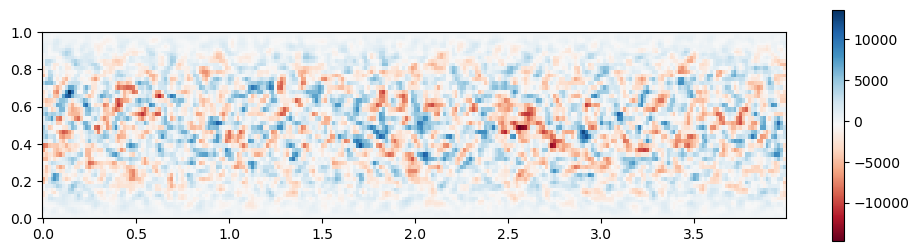

In [84]:
fig, ax = plt.subplots(figsize=(12,3))
mesh = ax.pcolormesh(data.x, data.z, data.theta.isel(t=-1).T, cmap='RdBu')
ax.set_aspect('equal')
# mesh.set_clim(-5e4, 5e4)
fig.colorbar(mesh, ax=ax)